# Functional Maps

This notebook is part of the lab semiar [Current research topics in visual and data-centric computing](https://www.fu-berlin.de/vv/en/lv/873230?m=428943&pc=575084&sm=814672) at Freie Universität Berlin.

This session will be on the *functional maps* framework that expresses correspondences between shapes in terms of maps between real-valued functions on the shapes.

Outline:
* Data
* Manifold Harmonics
* Functional maps
* Recovering point-to-point maps
* Spectral upsampling


## Setup environment

Let's install the required python packages, in particular:
* [robust-laplacian](https://github.com/nmwsharp/robust-laplacians-py) and SciPy for computing manifold harmonics
* [PyVista](https://docs.pyvista.org/) for visualization of surfaces and functions on it (requires openGL, hence, installation of `xvfb` and `mesa` system components)

In [1]:
#%%capture
!brew update
!brew install xvfb
!brew install --cask xquartz
!brew install mesa
!pip install pyvista meshio tqdm requests robust-laplacian scipy

==> Updating Homebrew...
Installing from the API is now the default behaviour!
You can save space and time by running:
  brew untap homebrew/core
Updated 2 taps (homebrew/core and homebrew/cask).
==> New Formulae
kubelogin                                poutine
==> New Casks
xnapper
==> Outdated Formulae
autoconf        haskell-stack   libomp          postgresql@14   sqlite
cmake           icu4c           mpdecimal       pyenv           xz
gcc             isl             mpfr            python@3.10     zstd
ghc             krb5            openjdk         python@3.9
gmp             libmpc          openssl@1.1     readline

You have 23 outdated formulae installed.
You can upgrade them with brew upgrade
or list them with brew outdated.
==> Searching for similarly named formulae and casks...
Error: No formulae or casks found for xvfb.
To reinstall 24.0.7, run:
  brew reinstall mesa


In [2]:
import pyvista as pv

# Seems that only static plotting is supported on colab at the moment
pv.global_theme.jupyter_backend = 'static'
pv.global_theme.notebook = True
pv.start_xvfb()

## Data

We will be working with the [FAUST](https://ps.is.mpg.de/research_projects/faust-dataset) shape dataset. FAUST comes with high-quality correspondences that serve as ground-truth. Here, we will try to recover correspondence for remeshed versions of the original data that have been created/used in:  

> Donati, N., Sharma, A., & Ovsjanikov, M.:  
> **[Deep geometric functional maps: Robust feature learning for shape correspondence.](https://arxiv.org/pdf/2003.14286)**  
> In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition, pp 8592-8601, 2020.</br>
> [![arXiv](https://img.shields.io/badge/arXiv-2003.14286-red)](https://arxiv.org/abs/2003.14286)

In [2]:
from tqdm import tqdm
import requests
import shutil

response = requests.get('https://nuage.lix.polytechnique.fr/index.php/s/LJFXrsTG22wYCXx/download?path=%2F&files=FAUST_r.zip', stream=True)

with open("FAUST_r.zip", "wb") as handle:
    for data in tqdm(response.iter_content()):
        handle.write(data)

shutil.unpack_archive('FAUST_r.zip', 'FAUST_r')

ConnectTimeout: HTTPSConnectionPool(host='nuage.lix.polytechnique.fr', port=443): Max retries exceeded with url: /index.php/s/LJFXrsTG22wYCXx/download?path=%2F&files=FAUST_r.zip (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x141756550>, 'Connection to nuage.lix.polytechnique.fr timed out. (connect timeout=None)'))

## Manifold Harmonics

On surfaces the eigenfunctions of the Laplace-Beltrami operator provide a Fourier-like basis called manifold harmonics.

In [3]:
from robust_laplacian import mesh_laplacian
import numpy as np
from scipy import sparse

def mfd_harmonics(surf: pv.PolyData, n: int):
  # setup generalized eigensystem
  v = np.asarray(surf.points)
  f = np.asarray(surf.faces.reshape(-1, 4)[:, 1:])

  print(f"Number of vertices: {v.shape[0]}")
  print(f"Number of faces: {f.shape[0]}")

  S, M = mesh_laplacian(v, f)
  # solve generalized eigenvalue problem S * v = lambda * M * v
  # (M is diagonal, thus, speed up using change of variables u = M^.5 * v)
  sqrtMinv = sparse.diags(1 / np.sqrt(M.data))
  evals, evecs = sparse.linalg.eigsh(sqrtMinv @ S @ sqrtMinv, n, sigma=-1e-8)
  return evals, sqrtMinv @ evecs, M

Number of vertices: 5000
Number of faces: 9996


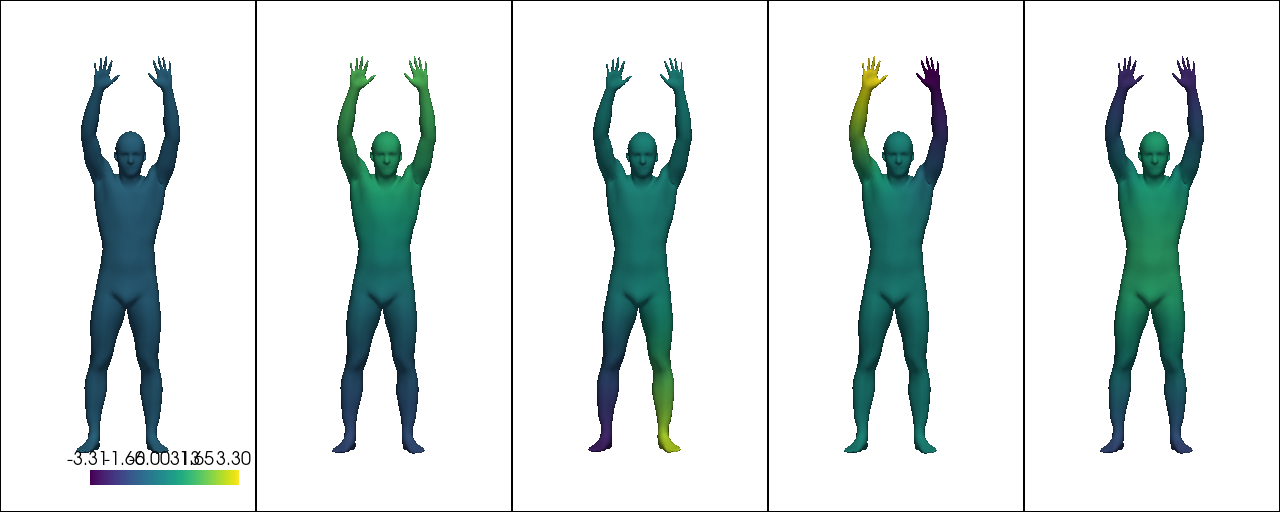

In [4]:
# load mesh and compute harmonics
mesh = pv.read('FAUST_r/off_2/tr_reg_099.off').extract_surface()
_, vecs, _ = mfd_harmonics(mesh, 100)

# show harmonics
pl = pv.Plotter(notebook=True, shape=(1,5))
for i in range(5):
    pl.subplot(0, i)
    pl.add_mesh(mesh.copy(), scalars=vecs.T[i], smooth_shading=True)
    pl.view_xy()
    pl.camera.zoom(3)
pl.show(window_size=(1280,512))

## Functional maps

> Ovsjanikov, M., Ben-Chen, M., Solomon, J., Butscher, A., & Guibas, L.:</br>
> **[Functional maps: a flexible representation of maps between shapes.](https://people.csail.mit.edu/jsolomon/assets/fmaps.pdf)**  
> ACM Transactions on Graphics, 31(4), pp. 1-11, 2012.</br>
> [![DOI](https://img.shields.io/badge/DOI-10.1145/2185520.2185526-yellow)](https://doi.org/10.1145/2185520.2185526)

> <img src="https://cdn-icons-png.freepik.com/256/8089/8089604.png?semt=ais_hybrid" alt="drawing" width="100"/> <br>
> * Initialize 4x4 functional map $C$ by hand
> * Assess quality visually by inspecting spectral embeddings

In [5]:
# load meshes and compute harmonics
S = pv.read('FAUST_r/off_2/tr_reg_000.off').extract_surface()
lambda_S, phi_S, M_S = mfd_harmonics(S, 30)
T = pv.read('FAUST_r/off_2/tr_reg_099.off').extract_surface()
lambda_T, phi_T, M_T = mfd_harmonics(T, 30)

print(f"Shape of phi_S: {phi_S.shape}")
print(f"Shape of phi_T: {phi_T.shape}")

# init 4x4 functional map
C = np.eye(4)
# TODO: set entries by hand

# Initialize 4x4 functional map C manually
C = np.array([
    [1.0, 0.01, 0.0, 0.0],   
    [0.01, -1.0, 0.02, 0.0],   
    [0.0, 0.02, 1.0, 0.01],
    [0.0, 0.0, 0.01, -1.0]
])


Number of vertices: 4999
Number of faces: 9994
Number of vertices: 5000
Number of faces: 9996
Shape of phi_S: (4999, 30)
Shape of phi_T: (5000, 30)


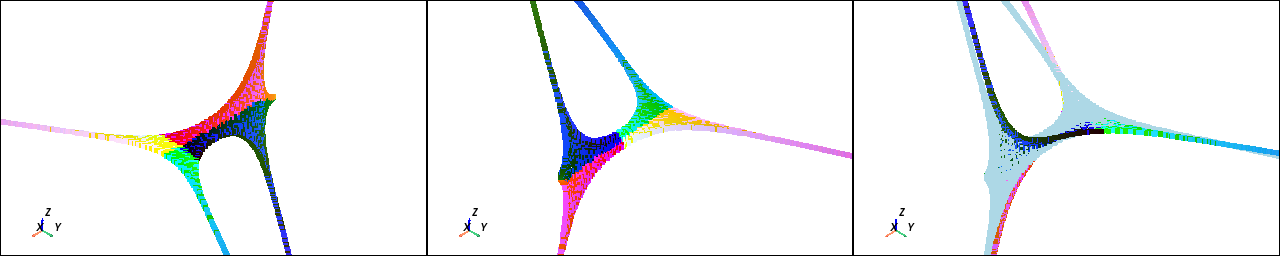

In [5]:
# show spectral embedding
pl = pv.Plotter(notebook=True, shape=(1,3))
# source mesh
pl.add_mesh(pv.PolyData(phi_S[:, 1:4]), scalars=S.points, rgb=True)
pl.add_axes()
# target mesh
pl.subplot(0, 1)
pl.add_mesh(pv.PolyData(phi_T[:, 1:4]), scalars=T.points, rgb=True)
pl.add_axes()
# target aligned
pl.subplot(0, 2)
pl.add_mesh(pv.PolyData(phi_S[:, 1:4] @ C[1:,1:].T), scalars=S.points, rgb=True)
pl.add_mesh(pv.PolyData(phi_T[:, 1:4]))
pl.add_axes()

pl.link_views()
pl.camera.zoom(8)

pl.show(window_size=(1280,256))


> <img src="https://cdn-icons-png.freepik.com/256/8089/8089604.png?semt=ais_hybrid" alt="drawing" width="100"/> <br>
> * Initialize 4x4 functional map $C$ by solving least-sqaures problem $\min_C||Cx^M - x^N||^2$ <br>
> ($x^S = \Phi^{S^T} M^S v$ denotes the representation of the mesh geometry $v = (v_0, v_1, \ldots) \in \mathbb{R}^{n \times 3}$)
> * Assess quality visually by inspecting spectral embeddings

## Recovering point-to-point maps

> <img src="https://cdn-icons-png.freepik.com/256/8089/8089604.png?semt=ais_hybrid" alt="drawing" width="100"/> <br>
> * Recover point-to-point correspondence $\Pi$ that maps spectral embedding $\Phi^M C^T$ to $\Phi^N$
> * e.g. using `sklearn.neighbors.NearestNeighbors` package


Shape of phi_S: (4999, 30)
Shape of phi_T: (5000, 30)
Point-to-point correspondence:
[ 304  969  304 ... 2796 2712 3872]


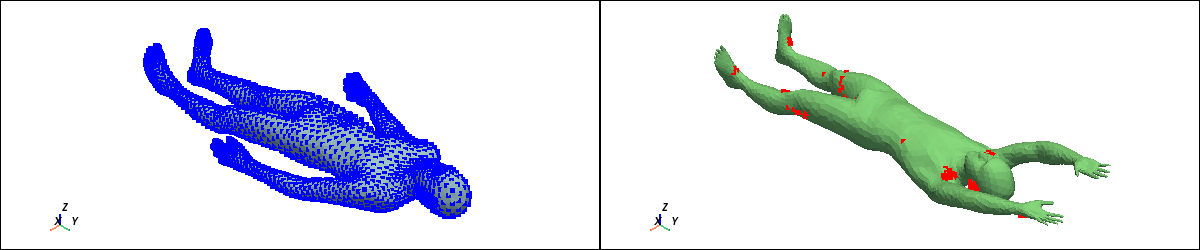

In [6]:
from tqdm import tqdm
import requests
import shutil

import numpy as np
import pyvista as pv
from scipy.linalg import lstsq
from sklearn.neighbors import NearestNeighbors

# Print shapes to verify
print(f"Shape of phi_S: {phi_S.shape}")
print(f"Shape of phi_T: {phi_T.shape}")

phi_S_adjusted = phi_S  # [:min_rows, :4]
phi_T_adjusted = phi_T  # [:min_rows, :4]

# Step 1: Initialize 4x4 functional map C by solving a least-squares problem
# C, _, _, _ = lstsq(phi_S_adjusted, phi_T_adjusted)


def generalized_lstsq(phi_S_adjusted, phi_T_adjusted):
    # Get dimensions
    m_s, n_s = phi_S_adjusted.shape
    m_t, n_t = phi_T_adjusted.shape

    # Construct the design matrix A and the right-hand side b
    A = np.zeros((m_s + m_t, n_s))
    b = np.zeros((m_s + m_t, n_t))

    A[:m_s, :] = phi_S_adjusted
    A[m_s:, :] = -phi_T_adjusted

    b[:m_s, :] = phi_S_adjusted
    b[m_s:, :] = phi_T_adjusted

    # Solve the generalized least squares problem
    C, residuals, rank, singular_values = np.linalg.lstsq(A, b, rcond=None)

    return C


# Solve for C
C = generalized_lstsq(phi_S_adjusted, phi_T_adjusted)




# Step 3: Recover point-to-point correspondence
transformed_phi_S = phi_S_adjusted @ C

# Fit nearest neighbors on the target spectral embeddings
nn = NearestNeighbors(n_neighbors=1).fit(phi_T_adjusted)

# Find the nearest neighbors for each point in the source spectral embeddings
distances, indices = nn.kneighbors(transformed_phi_S)

# The indices of the nearest neighbors are the point-to-point correspondences
point_to_point_correspondence = indices.flatten()

# Print the correspondence
print("Point-to-point correspondence:")
print(point_to_point_correspondence)

# Visualize the correspondence
pl = pv.Plotter(notebook=True, shape=(1, 2))

# Source mesh
pl.subplot(0, 0)
pl.add_mesh(S, color='lightblue', label='Source Mesh')
pl.add_points(S.points, color='blue', point_size=5)
pl.add_axes()

# Target mesh with corresponded points
pl.subplot(0, 1)
pl.add_mesh(T, color='lightgreen', label='Target Mesh')
pl.add_points(T.points[point_to_point_correspondence], color='red', point_size=5)
pl.add_axes()

pl.link_views()
pl.camera.zoom(3)
pl.show(window_size=(1200, 250))


## Spectral upsampling for functional map estimation

> Melzi, S., Ren, J., Rodola, E., Sharma, A., Wonka, P., & Ovsjanikov, M.:  
> **[ZoomOut: spectral upsampling for efficient shape correspondence.](https://arxiv.org/pdf/1904.07865)**  
> ACM Transactions on Graphics, 38(6), pp 1–14, 2019.</br>
> [![DOI](https://img.shields.io/badge/DOI-10.1145/3355089.3356524-yellow)](https://doi.org/10.1145/3355089.3356524) [![arXiv](https://img.shields.io/badge/arXiv-1904.07865-red)](https://arxiv.org/abs/1904.07865)


> <img src="https://cdn-icons-png.freepik.com/256/8089/8089604.png?semt=ais_hybrid" alt="drawing" width="100"/> <br>
> * Implement the ZoomOut algorithm (see Section 4 in [Melzi et al. 2019])
> * Evaluate the quality of the resulting correspondence depending on
>   - similarity of source and target shape
>   - choice of step size
>   - final dimensions of $C$

Mean Squared Error (MSE) between original and zoomed-out correspondences: 1053646.9945989198
Hausdorff Distance between transformed_phi_S and phi_T_adjusted: 3.6854421916587166


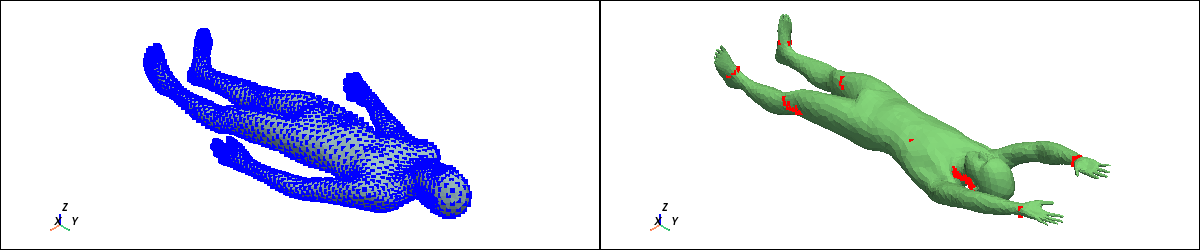

In [7]:
import numpy as np
import pyvista as pv
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import directed_hausdorff

def zoom_out_algorithm(phi_S_adjusted, phi_T_adjusted, C, num_steps, step_size):
    m_s, n_s = phi_S_adjusted.shape
    m_t, n_t = phi_T_adjusted.shape
    
    C_current = C.copy()  # Start with the initial C obtained from least squares
    
    for i in range(num_steps):
        current_size = m_s - i * step_size
        
        # Adjust the size of C_current
        C_current = C_current[:current_size, :]
        
        # Compute the transformed phi_S
        transformed_phi_S = phi_S_adjusted @ C_current
        
        # Fit nearest neighbors on the target spectral embeddings
        nn = NearestNeighbors(n_neighbors=1).fit(phi_T_adjusted)
        
        # Find the nearest neighbors for each point in the source spectral embeddings
        distances, indices = nn.kneighbors(transformed_phi_S)
        
        # The indices of the nearest neighbors are the point-to-point correspondences
        point_to_point_correspondence = indices.flatten()
        
        # Ensure indices are within valid range
        point_to_point_correspondence = point_to_point_correspondence[:current_size]
        
        # Refit C using least squares
        phi_S_adjusted_subset = phi_S_adjusted[:current_size, :]
        phi_T_adjusted_subset = phi_T_adjusted[point_to_point_correspondence]
        
        # Ensure phi_S_adjusted_subset and phi_T_adjusted_subset have compatible shapes
        if phi_S_adjusted_subset.shape[0] != phi_T_adjusted_subset.shape[0]:
            raise ValueError("Subset sizes are not compatible for least squares fitting.")
        
        C_current, residuals, rank, singular_values = np.linalg.lstsq(phi_S_adjusted_subset, phi_T_adjusted_subset, rcond=None)
    
    return C_current

# Example usage:
# Assuming phi_S_adjusted, phi_T_adjusted, and C_initial are already defined with appropriate shapes
num_steps = 4
step_size = 100

C_zoomed_out = zoom_out_algorithm(phi_S_adjusted, phi_T_adjusted, C, num_steps, step_size)

# Now you can use C_zoomed_out for further analysis or visualization
# Evaluate the quality of the resulting correspondence based on your criteria

# Step 3: Evaluate the quality of the resulting correspondence
# You can evaluate based on similarity of source and target shape, choice of step size, and final dimensions of C
# For example, compare original correspondence with zoomed out correspondence

# Recover point-to-point correspondence using the final C_zoomed_out
transformed_phi_S = phi_S_adjusted @ C_zoomed_out

nn = NearestNeighbors(n_neighbors=1).fit(phi_T_adjusted)
distances, indices = nn.kneighbors(transformed_phi_S)
point_to_point_correspondence_zoomed_out = indices.flatten()

# Calculate mean squared error (MSE) between original correspondence and zoomed-out correspondence
mse = np.mean((point_to_point_correspondence - point_to_point_correspondence_zoomed_out) ** 2)
print(f"Mean Squared Error (MSE) between original and zoomed-out correspondences: {mse}")

# Calculate Hausdorff distance
hausdorff_distance = directed_hausdorff(transformed_phi_S, phi_T_adjusted)[0]
print(f"Hausdorff Distance between transformed_phi_S and phi_T_adjusted: {hausdorff_distance}")

# Visualize the correspondence after ZoomOut
pl_zoomed_out = pv.Plotter(notebook=True, shape=(1, 2))

# Source mesh with zoomed out correspondence
pl_zoomed_out.subplot(0, 0)
pl_zoomed_out.add_mesh(S, color='lightblue', label='Source Mesh (ZoomOut)')
pl_zoomed_out.add_points(S.points, color='blue', point_size=5)
pl_zoomed_out.add_axes()

# Target mesh with zoomed out correspondence
pl_zoomed_out.subplot(0, 1)
pl_zoomed_out.add_mesh(T, color='lightgreen', label='Target Mesh (ZoomOut)')
pl_zoomed_out.add_points(T.points[point_to_point_correspondence_zoomed_out], color='red', point_size=5)
pl_zoomed_out.add_axes()

pl_zoomed_out.link_views()
pl_zoomed_out.camera.zoom(3)
pl_zoomed_out.show(window_size=(1200, 250))


## Optional: Comparison to non-rigid registration

> <img src="https://cdn-icons-png.freepik.com/256/8089/8089604.png?semt=ais_hybrid" alt="drawing" width="100"/> <br>
> * Use a non-rigid registration routine to estimate a point-to-point correspondence for shape pair
> * Compare to the correspondence obtained via the functional maps approach
> * E.g. use *coherent point drift* (python implementation [here](https://github.com/siavashk/pycpd))